In [1]:
import random

import torch
import numpy as np
import cv2 as cv
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.manifold import TSNE

from maskrcnn_benchmark.structures.bounding_box import BoxList
from maskrcnn_benchmark.structures.boxlist_ops import boxlist_iou

In [2]:
def _pairwise_l2_dist(
    embs: torch.Tensor,
    *,
    squared: bool = False,
    eps: float = 1e-16
) -> torch.Tensor:
    dot_product = torch.matmul(embs, embs.T)  # [B,B]
    square_norm = torch.diag(dot_product)  # [B,]

    # Apply the l2 norm formula using the dot product:
    # ||A - B||^2 = ||A||^2 - 2<A,B> + ||B||^2
    distances = (
        torch.unsqueeze(square_norm, dim=1) -  # [B,1]
        (2 * dot_product) +  # [B,B]
        torch.unsqueeze(square_norm, dim=0)  # [1,B]
    )

    # Due to potential errors caused by numerical instability, some values may
    # have become negative. Thus, we have to make sure the min. value is zero.
    zero = torch.tensor(0.0)
    distances = torch.maximum(distances, zero)  # [B,B]

    if not squared:
        # Since the gradient of sqrt(0) is infinite, we, therefore, have to
        # add a small epsilon to the zero terms to prevent this.
        zeroes_mask = ((distances - zero) < eps).float()  # [B,B]
        distances += zeroes_mask * eps
        
        distances = torch.sqrt(distances)  # [B,B]

        # Set all the "zero" values back to zero after adding the epsilon value.
        distances *= (1.0 - zeroes_mask)
    
    return distances

def _get_anchor_positive_mask(labels: torch.Tensor) -> torch.Tensor:
    labels_eq_mask = (labels[..., None] == labels[None, ...])  # [B,B]
    idxs_neq_mask = ~torch.eye(len(labels), dtype=torch.bool)  # [B,B]
    anchor_positive_mask = (labels_eq_mask & idxs_neq_mask)  # [B,B]
    return anchor_positive_mask

def _get_anchor_negative_mask(labels: torch.Tensor) -> torch.Tensor:
    anchor_negative_mask = (labels[..., None] != labels[None, ...])  # [B,B]
    return anchor_negative_mask

def get_triplet_mask(labels: torch.Tensor) -> torch.Tensor:
    idxs_neq_mask = ~torch.eye(len(labels), dtype=torch.bool)  # [B,B]
    idx_i_neq_j_mask = torch.unsqueeze(idxs_neq_mask, dim=2)  # [B,B,1]
    idx_i_neq_k_mask = torch.unsqueeze(idxs_neq_mask, dim=1)  # [B,1,B]
    idx_j_neq_k_mask = torch.unsqueeze(idxs_neq_mask, dim=0)  # [1,B,B]
    triplet_idxs_neq_mask = (
        idx_i_neq_j_mask & idx_i_neq_k_mask & idx_j_neq_k_mask  # [B,B,B]
    )

    labels_eq_mask = (labels[..., None] == labels[None, ...])  # [B,B]
    label_i_eq_j = torch.unsqueeze(labels_eq_mask, dim=2)  # [B,B,1]
    label_i_neq_k = ~torch.unsqueeze(labels_eq_mask, dim=1)  # [B,1,B]
    triplet_labels_valid_mask = (label_i_eq_j & label_i_neq_k)  # [B,B,B]

    triplet_mask = (
        triplet_idxs_neq_mask & triplet_labels_valid_mask  # [B,B,B]
    )

    return triplet_mask

class SemiHardTripletLoss(nn.Module):
    def __init__(self, margin: float = 1.0, squared: bool = True) -> None:
        super().__init__()

        self.margin: float = margin
        self.squared: bool = squared
    
    def forward(self, embs: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        pairwise_dist = _pairwise_l2_dist(embs, squared=self.squared)

        anchor_positive_mask = _get_anchor_positive_mask(
            labels
        ).float()  # [B,B]
        anchor_positive_dist = pairwise_dist * anchor_positive_mask  # [B,B]
        hardest_positive_dist = torch.amax(
            anchor_positive_dist, dim=1, keepdim=True
        )  # [B,1]

        anchor_negative_mask = _get_anchor_negative_mask(
            labels
        ).float()  # [B,B]
        max_anchor_negative_dist = torch.amax(
            pairwise_dist, dim=1, keepdim=True
        )  # [B,1]
        anchor_negative_dist = (
            pairwise_dist +
            (1 - anchor_negative_mask) * max_anchor_negative_dist
        )  # [B,B]
        hardest_negative_dist = torch.amin(
            anchor_negative_dist, dim=1, keepdim=True
        )  # [B,1]

        triplet_loss = torch.clamp(
            hardest_positive_dist - hardest_negative_dist + self.margin, min=0
        )  # [B,1]
        triplet_loss = torch.mean(triplet_loss)  # [c]

        return triplet_loss

In [3]:
B = 128
E = 16
n_classes = 5

lr = 1e-2
n_epochs = 5000
print_step = 500
embs = torch.randint(0, 5, (B, E), dtype=torch.float, requires_grad=True)
labels = torch.randint(0, n_classes, (B,))
criterion = SemiHardTripletLoss()

optimizer = torch.optim.SGD([embs], lr=lr)
for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = criterion(embs, labels)
    loss.backward()
    optimizer.step()
    if (epoch % print_step) == 0:
        print(f"[{epoch + 1}/{n_epochs}] loss={loss.item():.6f}")

[1/5000] loss=70.953125
[501/5000] loss=37.987583
[1001/5000] loss=25.344738
[1501/5000] loss=18.505264
[2001/5000] loss=14.080376
[2501/5000] loss=10.849096
[3001/5000] loss=8.175941
[3501/5000] loss=5.705865
[4001/5000] loss=3.232817
[4501/5000] loss=1.086237


E:\venvs\siam-mot\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


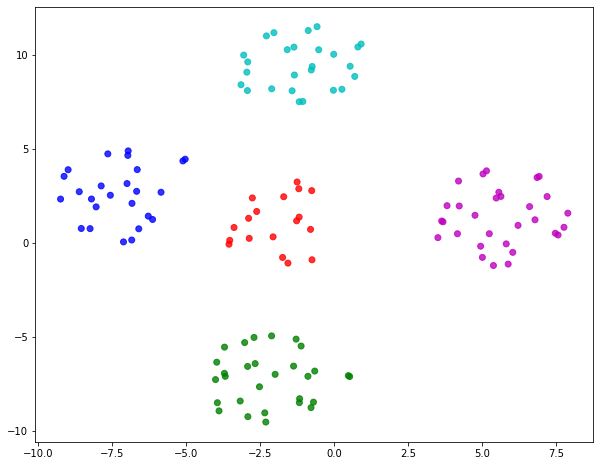

In [4]:
def init_colors(n_colors, *, randomize=True):
    colors =  list(mcolors.BASE_COLORS.keys())
    if randomize:
        random.shuffle(colors)
    return colors[:n_colors]

tsne = TSNE(n_components=2, n_iter=3000, metric='cosine')
embs_reduced = tsne.fit_transform(embs.detach().numpy())

class_colors = init_colors(n_classes, randomize=False)
color_seq = [class_colors[label] for label in labels.tolist()]

fig, ax = plt.subplots(figsize=(10, 8))
xs = embs_reduced[:, 0]
ys = embs_reduced[:, 1]
ax.scatter(xs, ys, alpha=0.8, c=color_seq)

In [9]:
def features_to_emb(features: torch.Tensor) -> torch.Tensor:
    """Computes embedding vectors from tracker template (exemplar) features.
    For each feature tensor in a batch, it applies global average pooling along
    the channel dimension. Afterwards, it L2-normalizes the vectors to project
    them onto a unit hypersphere.

    Args:
        features (torch.Tensor): template features of shape [B, C, S, S]

    Returns:
        torch.Tensor: embedding vectors of shape [B, C]
    """
    batch_size, n_channels, kernel_size, _ = features.shape
    avg = F.avg_pool2d(features, kernel_size=kernel_size)   # [B, C, 1, 1]
    avg  = avg.reshape((batch_size, n_channels))  # [B, C]
    norm = torch.linalg.norm(avg, dim=1)  # [B,]
    emb = avg / norm[..., None]  # [B, C]
    
    return emb

features = torch.rand((1, 128, 15, 15))
features_to_emb(features).shape

torch.Size([1, 128])